In [3]:
%load_ext autoreload
%autoreload 2

In [7]:
from diffusers import StableDiffusionControlNetImg2ImgPipeline, ControlNetModel, UniPCMultistepScheduler
import torch

In [5]:
controlnet = ControlNetModel.from_pretrained("lllyasviel/control_v11f1p_sd15_depth", torch_dtype=torch.float16, use_safetensors=True)

config.json:   0%|          | 0.00/945 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

In [8]:
pipe = StableDiffusionControlNetImg2ImgPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16, use_safetensors=True
)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [11]:
data_config = {
  "dataset": "pandaset",
  "path": "/home/s0001900/dev/datasets/pandaset",
  "data_getters": {
    "rgb": {
      "camera": "front_camera",
      "height": 1080,
      "width": 1920
    },
    "lidar": {
        "height": 1080,
        "width": 1920
    },
    "meta": {}
  },
  "data_tree": {
    "pandaset": {
      "001": ["01"]
    }
  }
}

data_config

{'dataset': 'pandaset',
 'path': '/home/s0001900/dev/datasets/pandaset',
 'data_getters': {'rgb': {'camera': 'front_camera',
   'height': 1080,
   'width': 1920},
  'lidar': {'height': 1080, 'width': 1920},
  'meta': {}},
 'data_tree': {'pandaset': {'001': ['01']}}}

In [12]:
from pathlib import Path
from src.data import LidarDataGetter, PandasetInfoGetter, SampleInfo, IntrinsicsDataGetter, PoseDataGetter, RGBDataGetter



info_getter = PandasetInfoGetter()
rgb_getter = RGBDataGetter(info_getter, {})
lidar_getter = LidarDataGetter(info_getter, {})
intrinsics_getter = IntrinsicsDataGetter(info_getter, {})
pose_getter = PoseDataGetter(info_getter, {})

data_path = Path(data_config["path"])
sample_info = SampleInfo("pandaset", "001", "02")

ex_rgb = rgb_getter.get_data(data_path, sample_info)
ex_lidar =  lidar_getter.get_data(data_path, sample_info)
ex_intr = intrinsics_getter.get_data(data_path, sample_info)
ex_pose = pose_getter.get_data(data_path, sample_info)



In [13]:
lidar_pts = ex_lidar.to_numpy()[..., :3]

In [14]:
import numpy as np
import transforms3d as t3d


def _heading_position_to_mat(heading, position):
    quat = np.array([heading["w"], heading["x"], heading["y"], heading["z"]])
    pos = np.array([position["x"], position["y"], position["z"]])
    transform_matrix = t3d.affines.compose(np.array(pos),
                                           t3d.quaternions.quat2mat(quat),
                                           [1.0, 1.0, 1.0])
    return transform_matrix



def projection(lidar_points, image_w, image_h, camera_pose_mat, camera_intrinsics, filter_outliers=True):
    trans_lidar_to_camera = np.linalg.inv(camera_pose_mat)
    points3d_lidar = lidar_points
    points3d_camera = trans_lidar_to_camera[:3, :3] @ (points3d_lidar.T) + \
                        trans_lidar_to_camera[:3, 3].reshape(3, 1)

    inliner_indices_arr = np.arange(points3d_camera.shape[1])
    if filter_outliers:
        condition = points3d_camera[2, :] > 0.0
        points3d_camera = points3d_camera[:, condition]
        inliner_indices_arr = inliner_indices_arr[condition]

    K = np.eye(3, dtype=np.float64)
    K[0, 0] = camera_intrinsics["fx"]
    K[1, 1] = camera_intrinsics["fy"]
    K[0, 2] = camera_intrinsics["cx"]
    K[1, 2] = camera_intrinsics["cy"]
    points2d_camera = K @ points3d_camera
    points2d_camera = (points2d_camera[:2, :] / points2d_camera[2, :]).T

    if filter_outliers:
        condition = np.logical_and(
            (points2d_camera[:, 1] < image_h) & (points2d_camera[:, 1] > 0),
            (points2d_camera[:, 0] < image_w) & (points2d_camera[:, 0] > 0))
        points2d_camera = points2d_camera[condition]
        points3d_camera = (points3d_camera.T)[condition]
        inliner_indices_arr = inliner_indices_arr[condition]

    return points2d_camera, points3d_camera, inliner_indices_arr


camera_pose_mat = _heading_position_to_mat(ex_pose["heading"], ex_pose["position"])
points2d_camera, points3d_camera, inliner_indices_arr = projection(lidar_pts, 1920, 1080, camera_pose_mat, ex_intr)

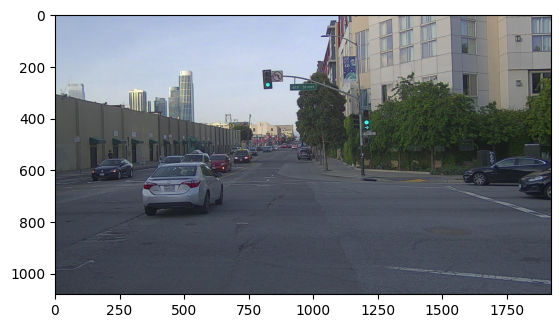

In [18]:
import matplotlib.pyplot as plt


plt.imshow(ex_rgb.permute(1, 2, 0))

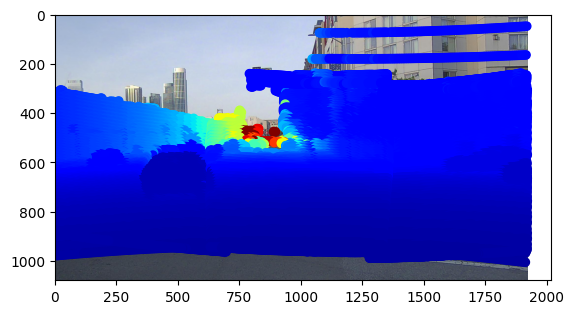

In [21]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np


plt.imshow(ex_rgb.permute(1, 2, 0))
dists = np.sqrt(np.sum(np.square(points3d_camera), axis=-1))
colors = cm.jet(dists / dists.max())
plt.scatter(points2d_camera[:, 0], points2d_camera[:, 1], c=colors)

## Dino

In [29]:
import torch

In [27]:
from transformers import AutoImageProcessor, AutoModelForDepthEstimation


depth_image_processor = AutoImageProcessor.from_pretrained("LiheYoung/depth-anything-small-hf")
depth_model = AutoModelForDepthEstimation.from_pretrained("LiheYoung/depth-anything-small-hf")


In [49]:
inputs = depth_image_processor(images=ex_rgb, return_tensors="pt", do_rescale=False)

with torch.no_grad():
    dep_outputs = depth_model(**inputs)
    pred_dep = dep_outputs.predicted_depth

In [55]:
pred_dep_sized = torch.nn.functional.interpolate(
    pred_dep.unsqueeze(1),
    size=ex_rgb.shape[1:],
    mode="bicubic",
    align_corners=False,
)[0]


In [78]:
print(pred_dep_sized.mean())

tensor(8.5760)


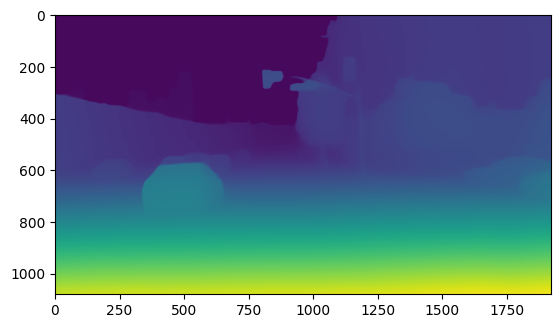

In [91]:
plt.imshow(pred_dep_sized.permute(1, 2, 0) / pred_dep_sized.max())

In [155]:
pred_dep_2 = torch.clone(pred_dep_sized)
dists_2 = dists.copy()
#dists_2[(dists_2 < 0) | (dists_2 > 50)] = -1
for i, (x, y) in enumerate(points2d_camera):
    if dists_2[i] < 0:
        continue

    pred_dep_2[0, int(y), int(x)] = dists_2[i] 

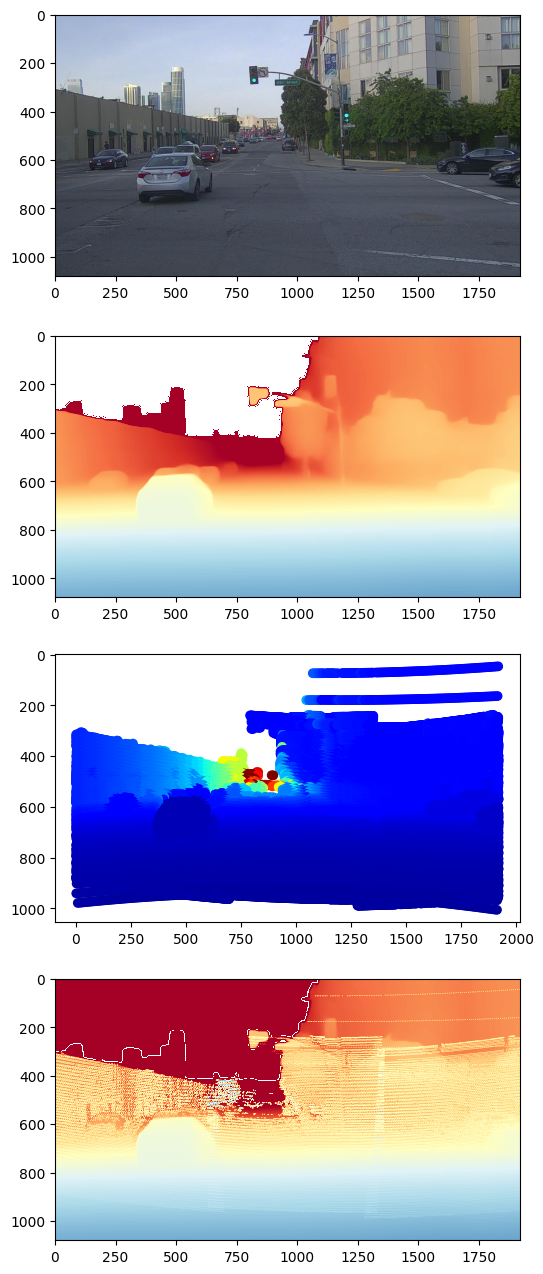

In [193]:
import matplotlib.cbook as cbook
import matplotlib.colors as colors

fig, (ax0, ax1, ax2, ax3) = plt.subplots(4, 1, figsize=(6, 16))
VMIN = 2
VMAX = 50
CMAP = 'RdYlBu'

ax0.imshow(ex_rgb.permute(1, 2, 0))
ax1.imshow(pred_dep_sized.permute(1, 2, 0),  norm=colors.LogNorm(vmin=VMIN, vmax=VMAX, clip=False), cmap=CMAP)
ax2.scatter(points2d_camera[:, 0], points2d_camera[:, 1], c=cm.jet(dists / dists.max()))
ax2.invert_yaxis()
ax3.imshow(pred_dep_2.permute(1, 2, 0),  norm=colors.LogNorm(vmin=VMIN, vmax=VMAX, clip=False), cmap=CMAP)
#pcolor(X, Y, Z, norm=colors.LogNorm(vmin=Z.min(), vmax=Z.max()), cmap='PuBu_r', shading='auto')

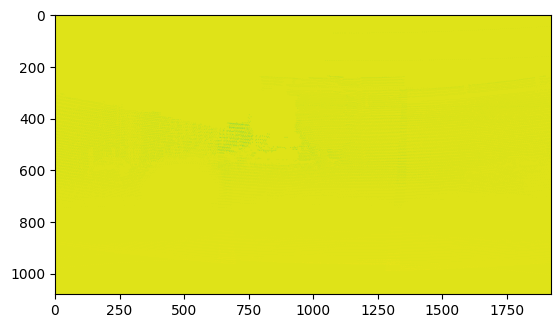

In [198]:
dmap = pred_dep_sized - pred_dep_2
plt.imshow(dmap.permute(1, 2, 0))

In [77]:
print(dists.std())

23.74084452371111
